# 3D Engine!

Fontes:

- [ ] [Build your own a Ray Tracer](https://avikdas.com/build-your-own-raytracer/)

Okay. Nossa câmera será um vetor, denotado por $\vec{C}$. Mas também precisamos de um plano, que representa a tela, chamado Plano de imagem. Todos os raios serão lançados desse plano, com direção da câmera. Se esse plano é definido pelos vértices $\vec{x}_1, \vec{x}_2, \vec{x}_3, \vec{x}_4$:

$$ \vec{t} = (1 - \alpha)\vec{x}_1 + \alpha\vec{x}_2 $$
$$ \vec{b} = (1 - \alpha)\vec{x}_3 + \alpha\vec{x}_4 $$
$$ \vec{o} = (1 - \beta)\vec{t} + \beta\vec{b} $$

Sendo que $\alpha$ é a porcentagem do píxel em relação a largura da imagem (o $i$-ésimo pixel numa imagem com largura $w$ tem $\alpha = \frac{i}{w}$). O $\beta$ refere-se a altura.

Assim, a direção do raio de cada pixel é

$$ \vec{d} = \vec{o} - \vec{C} $$

In [293]:
import numpy as np

w, h = 512, 512
r  = h/w # ratio
C  = np.array([ 0,  0, -1]) # x, y, z
x1 = np.array([-1,  r,  0]) # top-left
x2 = np.array([ 1,  r,  0]) # top-right
x3 = np.array([-1, -r,  0]) # bottom-left
x4 = np.array([ 1, -r,  0]) # bottom-right

imagePlane = np.zeros((w, h, 2, 3))
for x in range(w):
  alpha = x/w
  t = (1 - alpha) * x1 + alpha * x2
  b = (1 - alpha) * x3 + alpha * x4
  for y in range(h):
    beta = y/h
    o = (1 - beta)*t + beta*b
    # Guarda origem e direção 
    imagePlane[x, y, 0] = o
    imagePlane[x, y, 1] = o - C

del t, b, o, x, r, alpha, beta

Vamos visualizar o que temos até aqui

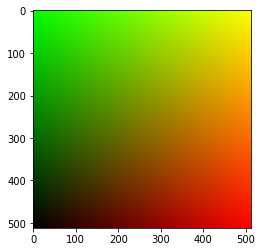

In [294]:
x = imagePlane[:,:,1,0]
y = imagePlane[:,:,1,1]
x = x - np.amin(x) # get length
y = y - np.amin(y) # get length
x = x / np.amax(x) # get percent
y = y / np.amax(y) # get percent

colors = np.zeros((w, h, 3))
colors[:,:,0] = x
colors[:,:,1] = y

del x
del y

from matplotlib.pyplot import imshow
%matplotlib inline

# matplotlib espera hxw
imshow(colors.transpose(1,0,2))

del colors

Yay!  

Raios no topo-esquerdo estão apontando pro topo-esquerdo como deveria ser. Observe que isso é verdade para todos os lados.

---

Estamos prontos pra adicionar esferas no nosso universo.

Todas as esferas precisarão ter pelo menos duas propriedades: posição e raio.

Para cada pixel, precisamos saber se o raio que sai dele intersecta alguma esfera. Ou seja, para cada esfera de raio $r$, centrada em $\vec{s}$, precisamos encontrar $t$ tal que

$$ dist(\vec{o} + \vec{d}t, \vec{s}) = r $$
$$ \Rightarrow \|\vec{o} + \vec{d}t - \vec{s}\| = r$$
$$ \Rightarrow \langle\vec{o} + \vec{d}t - \vec{s}, \vec{o} + \vec{d}t - \vec{s}\rangle = r^2 $$

Pra simplificar fazemos $\vec{s}' = \vec{o} - \vec{s}$:

$$ \langle\vec{s}' + \vec{d}t, \vec{s}' + \vec{d}t\rangle = r^2 $$
$$ = \langle\vec{s}' + \vec{d}t, \vec{s}'\rangle + \langle\vec{s}' + \vec{d}t, \vec{d}t\rangle = r^2 $$
$$ = \langle\vec{s}',\vec{s}'\rangle + \langle\vec{d}t,\vec{s}'\rangle + \langle\vec{s}',\vec{d}t\rangle + \langle\vec{d}t,\vec{d}t\rangle$$
$$ \|\vec{s}'\|^2 + t^2\|\vec{d}\|^2 + 2t\langle\vec{s}',\vec{d}\rangle $$

$$ \Rightarrow \|\vec{d}\|^2t^2 + 2\langle\vec{s}',\vec{d}\rangle t + (\|\vec{s}'\|^2 - r^2) = 0 $$

Para cada esfera, resolvemos a equação do segundo grau e escolhemos a menor solução (o ponto mais próximo). Se não houver solucão, o raio não intersecta uma esfera.

In [295]:
from math import sqrt
def quadraticSolution(a,b,c):
  delta = b*b - 4*a*c
  if delta < 0:
    return None
  if delta == 0:
    return -b/(2*a)
  delta = sqrt(delta)
  t1 = (-b + delta)/(2*a)
  t2 = (-b - delta)/(2*a)
  
  return min(t1, t2)

assert quadraticSolution(3,-7,4) == 1
assert quadraticSolution(9,-12,4) == 2/3
assert quadraticSolution(5,3,5) is None

In [296]:
spheres = np.array([
  # raio, xyz, rgb
  ( 2, ( 0,  2, 10), (1.,0.,0.)),
  (.6, (-1, .5,  2), (0.,1.,0.)),
  ( 5, (-1, -1, 15), (0.,0.,1.))
])

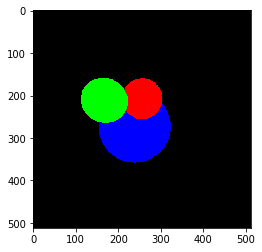

In [297]:
from numpy.linalg import norm

pixels = np.zeros((w,h,3))
for x in range(w):
  for y in range(h):
    o,d = imagePlane[x,y]
    a = norm(d)**2
    smallT = None
    color = None
    for sphere in spheres:
      r = sphere[0]
      s = o - sphere[1] # s'
      b = 2*np.dot(s,d)
      c = norm(s)**2 - r*r
      t = quadraticSolution(a,b,c)
      if t is not None:
        if smallT is None or t < smallT:
          smallT = t
          color = sphere[2]
    if color is not None:
      pixels[x,y] = color

# matplotlib espera hxw
imshow(pixels.transpose(1,0,2))

# clean
del pixels, x, y, o, d, a, smallT
del color, r, s, b, c, t

Yay!

Agora já podemos ver o que a câmera vê. Experimente alterar a posição de $\vec{C}$ e observe como isso altera a visão da câmera!

---

So far, so good.

Agora queremos adicionar profundidade às esferas. Para isso, vamos usar o modelo de iluminação de Phog.

O modelo de Phong possui três componentes básicos:

###### Luz de ambiente

A luz de ambiente emitirá luz com uma intensidade $i_a$. Os objetos no universo refletirão parte ($k_a$) dessa luz, resultando em num reflexo de intensidade $k_ai_a$.

###### Difusão

Para cada luz no cenário, os objetos refletirão uma parte ($k_d$) da itensidade $i_d$ dessa luz. A reflexão será em todas as direções.

A quantidade de luz refletida depende de como a luz acerta o objeto. Se $\hat{L}$ é o vetor da luz, e $\vec{N}$ é o vetor normal ao ponto onde o raio toca, a intensidade da luz difusa é dada por

$$ k_di_d\langle\vec{N},\vec{L}\rangle $$

###### Luz Especular

Para cada luz no cenário, pode existir uma luz especular, que é uma reflexão que depende do ângulo do observador. Se a reflexão vem direto pra câmera, então a intensidade é maior.

Se a luz especular é refletida na direção $\vec{R}$ numa proporção $k_s$, e o objeto tem constante de brilho $\alpha$, e o vetor direção da câmera para o ponto de reflexão é $\vec{V}$, então o resultado é

$$ k_si_s\langle\vec{V},\vec{R}\rangle^\alpha $$

E o vetor $\vec{R}$ é coputado da seguinte maneira:

$$ \vec{R} = 2\langle\vec{N}, \vec{L}\rangle\vec{N} - \vec{L} $$

Por último, o vetor normal ao ponto $\hat{p}$ da esfera centrada em $\hat{s}$ é:

$$ \vec{N} = \frac{\hat{p} - \hat{s}}{ \|\hat{p} - \hat{s}\|  } $$

É isto. Vamos criar, em nosso universo, luzes. Cada uma delas precisa ter as seguintes propriedades:

- posição
- intensidade difusa ($i_d$)
- intensidade especular ($i_s$)

Além disso, precisamos adicionar a luz de ambiente $i_a$.

$i_d$, $i_s$ e $i_a$ são, essensialmente, cores.

As esferas, agoram devem ter as seguintes propriedades:

- constante de ambiente $k_a$
- constante de difusão $k_d$
- constante especular $k_s$
- fator de brilho $\alpha$

$k_a$ é, essecialmente, a cor do objeto. As outras constantes são porcentagens de o quanto o material deve refletir em cada um dos canais RGB. $\alpha$ é um escalar.

In [300]:
spheres = np.array([
  # raio,          xyz,         ka,           kd,           ks,   𝛼
  (.5, ( 1.0, -.2, 1.4), (.1,.1,.1), (.9, .2, .2), (.7, .7, .7), 40),
  (.5, ( 0.2,  .1, 1.8), (0.,.4,0.), (.5, .5, .5), (.5, .5, .5), 40),
  (.3, (-1.6, 1.0, 2.5), (0.,0.,.4), (.5, .5, .5), (.5, .5, .5), 40)
])
lights = np.array([
    #       xyz,           id,         is
  ((-2, -.5, 1), (.8, .3, .3), (.8, .8, .8)),
  (( 2,  .5, 0), (.4, .4, .9), (.8, .8, .8))
])
ambientLight = np.array([.5, .5, .5])

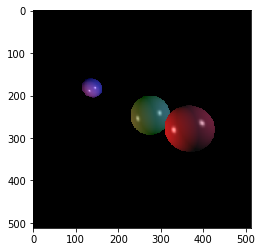

In [301]:
pixels = np.zeros((w,h,3))
for x in range(w):
  for y in range(h):
    o,d = imagePlane[x,y]
    a = norm(d)**2
    smallT = None
    smallS = None
    for sphere in spheres:
      r = sphere[0]
      s = o - sphere[1] # s'
      b = 2*np.dot(s,d)
      c = norm(s)**2 - r*r
      t = quadraticSolution(a,b,c)
      if t is not None:
        if smallT is None or t < smallT:
          smallT = t
          smallS = sphere
    if smallS is not None:
      p = o + d*smallT # ponto de intersecção
      s = smallS[1] # centro da esfera
      N = (p - s) / norm(p - s)
      # vamos calcular a cor
      ka, kd, ks, alpha = smallS[2:]
      V = C - p
      V = V / norm(V)
      color = ambientLight * ka
      for light in lights:
        L = light[0] - p
        L = L / norm(L)
        dot = np.dot(N, L) # luz na direção normal
        if dot < 0:
          # luz está vindo de dentro da esfera!
          continue
        difuse = kd * light[1] * dot
        # agora a luz especular
        R = 2*dot*N - L
        specular = (ks * light[2]) * (np.dot(V, R)**alpha)
        color = color + difuse + specular
        
      color = np.clip(color, 0, 1) # clamp
      pixels[x,y] = color

# matplotlib espera hxw
imshow(pixels.transpose(1,0,2))

# clean
del pixels, x, y, o, d, a, smallT
del smallS, r, s, b, c, t, p, N
del ka, kd, ks, alpha